In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation, MeanShift, OPTICS, Birch
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
import scipy.spatial.distance as dist
import itertools

df_songs = pd.read_csv('your_songs_database.csv')
df_songs.head()

# Scaling the data
scaler = MinMaxScaler()
data_standardized = scaler.fit_transform(df_songs.drop(['song_title', 'artist'], axis=1))

# PCA Visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_standardized)
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Visualization')
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_standardized)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization')
plt.show()

def euclidean_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

def cosine_dist(v1, v2):
    return dist.cosine(v1, v2)

### Cluster Algorithms
clustering_algorithms = [
    KMeans(),
    DBSCAN(),
    AgglomerativeClustering(),
    AffinityPropagation(),
    MeanShift(),
    OPTICS(),
    Birch()
]


# Helper function to compute silhouette scores and clustering labels
def apply_clustering(norm_func, dataset, algorithm):
    distance_matrix = dist.pdist(dataset, metric=norm_func)
    distance_matrix = dist.squareform(distance_matrix)
    if hasattr(algorithm, 'fit_predict'):
        labels = algorithm.fit_predict(distance_matrix)
    else:
        algorithm.fit(distance_matrix)
        labels = algorithm.labels_
    silhouette = silhouette_score(distance_matrix, labels, metric='precomputed')
    return labels, silhouette

# Prepare the results data structure
results = []

# Test combinations of norm functions and clustering algorithms
for norm_func in [euclidean_dist, cosine_dist]:
    for algorithm in clustering_algorithms:
        labels, silhouette = apply_clustering(norm_func, data_pca, algorithm)
        results.append({'norm_func': norm_func.__name__,
                        'algorithm': algorithm.__class__.__name__,
                        'silhouette': silhouette})
        # Visualize the clustering results for PCA and the corresponding norm function
        plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.title(f'PCA Clustering with {algorithm.__class__.__name__} ({norm_func.__name__} norm)')
        plt.show()

        # Visualize the clustering results for t-SNE and the corresponding norm function
        labels, silhouette = apply_clustering(norm_func, data_tsne, algorithm)
        plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='viridis')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.title(f't-SNE Clustering with {algorithm.__class__.__name__} ({norm_func.__name__} norm)')
        plt.show()

### Feature Selection


# Create a pipeline for K-means clustering with feature selection
pipeline = Pipeline([
    ('select_features', SelectKBest(score_func=f_classif)),
    ('clustering', KMeans())
])

# Grid search parameters to select the best value for K features
param_grid = {
    'select_features__k': list(range(1, data_standardized.shape[1] + 1)),
    'clustering__n_clusters': [optimal_k]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10)
grid.fit(data_standardized, kmeans_clusters)

# Plot the clustered data with the best K features
best_k = grid.best_params_['select_features__k']
selected_features = np.argsort(grid.best_estimator_.named_steps['select_features'].scores_)[-best_k:]
selected_data = data_standardized[:, selected_features]
data_pca_best_k = pca.fit_transform(selected_data)

plt.scatter(data_pca_best_k[:, 0], data_pca_best_k[:, 1], c=kmeans_clusters, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'PCA Clustering with Best K Features (K = {best_k})')
plt.show()

In [8]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, davies_bouldin_score,
                             adjusted_rand_score, normalized_mutual_info_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
import umap
from gap_statistic import OptimalK

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [9]:
import pandas as pd
df = pd.read_csv('embed.csv')
columns_to_drop = ['Unnamed: 0'] # list the column names to drop
df=df.drop(columns=columns_to_drop)

,track_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,...,album,popularity,genres,duration,explicit,album_id,artist_ids,lyrics,tokens,embeddings
414,3uYm4MtU6jUQft2DtGqEoZ,0.922,0.364,108.952,0.128,0.0353,0.0,4,0.667,4,...,Knock Knock - Single,62,"['hip hop', 'pittsburgh rap', 'rap']",202806,True,5ICp41WijCKVXXtxS0BVx8,['4LLpKhyESsyAXpc4laK94U'],in the air hey hey chorus one two three four s...,568,"[-0.004114056471735239, -0.0037777486722916365..."


In [228]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

df = pd.read_csv('embed.csv')
columns_to_drop = ['Unnamed: 0'] # list the column names to drop
df=df.drop(columns=columns_to_drop)
# Set "track_id" as the index
df.set_index("track_id", inplace=True)

# List of the 9 numerical audio features
audio_features = ['danceability', 'energy', 'key', 'mode', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'time_signature']

# Normalize features using Min-Max Scaling
minmax_scaler = MinMaxScaler()
np_minmax = minmax_scaler.fit_transform(df[audio_features])
df_minmax = pd.DataFrame(minmax_normalized_features, columns=audio_features, index=df.index)

# Normalize features using Z-Score Scaling
zscore_scaler = StandardScaler()
np_zscore = zscore_scaler.fit_transform(df[audio_features])
df_zscore = pd.DataFrame(zscore_normalized_features, columns=audio_features, index=df.index)

# Normalize features using Robust Scaling
robust_scaler = RobustScaler()
np_robust = robust_scaler.fit_transform(df[audio_features])
df_robust = pd.DataFrame(robust_normalized_features, columns=audio_features, index=df.index)

# Display the normalized dataframes
print("Min-Max Normalized Features:")
display(df_minmax.head())

print("\nZ-Score Normalized Features:")
display(df_zscore.head())

print("\nRobust Normalized Features:")
display(df_robust.head())

Min-Max Normalized Features:


,danceability,energy,key,mode,acousticness,instrumentalness,valence,tempo,time_signature
track_id,,,,,,,,,
2I12vOWeJU5ayhr6ha6esf,0.812183,0.494215,0.000000,1.0,0.020742,0.000021,0.182281,0.547058,0.8
70nmZhHZLNVYWP4NON41Zw,0.534010,0.611959,0.727273,0.0,0.067469,0.000251,0.190428,0.533046,0.8
1EaKU4dMbesXXd3BrLCtYG,0.759391,0.698986,0.363636,0.0,0.205435,0.000000,0.491853,0.903537,0.8
5WNYg3usc6H8N3MBEp4zVk,0.567513,0.568957,0.727273,1.0,0.795568,0.000544,0.243381,0.380360,0.8
2LMkwUfqC6S6s6qDVlEuzV,0.508629,0.075253,0.000000,1.0,0.775427,0.000000,0.207739,0.517410,0.8



Z-Score Normalized Features:


,danceability,energy,key,mode,acousticness,instrumentalness,valence,tempo,time_signature
track_id,,,,,,,,,
2I12vOWeJU5ayhr6ha6esf,0.903093,-0.526319,-1.391919,0.787859,-0.828340,-0.352333,-1.041763,-0.305602,0.127826
70nmZhHZLNVYWP4NON41Zw,-0.793857,0.112840,0.748884,-1.269263,-0.654697,-0.351275,-1.007188,-0.407410,0.127826
1EaKU4dMbesXXd3BrLCtYG,0.581044,0.585263,-0.321518,-1.269263,-0.142000,-0.352431,0.272074,2.284316,0.127826
5WNYg3usc6H8N3MBEp4zVk,-0.589480,-0.120592,0.748884,0.787859,2.050997,-0.349927,-0.782453,-1.516713,0.127826
2LMkwUfqC6S6s6qDVlEuzV,-0.948688,-2.800615,-1.391919,0.787859,1.976151,-0.352431,-0.933717,-0.521006,0.127826



Robust Normalized Features:


,danceability,energy,key,mode,acousticness,instrumentalness,valence,tempo,time_signature
track_id,,,,,,,,,
2I12vOWeJU5ayhr6ha6esf,0.564220,-0.367187,-0.625,0.0,-0.300778,0.006538,-0.621849,-0.280737,0.0
70nmZhHZLNVYWP4NON41Zw,-0.692661,0.082031,0.375,-1.0,-0.168367,0.104975,-0.599440,-0.349377,0.0
1EaKU4dMbesXXd3BrLCtYG,0.325688,0.414062,-0.125,-1.0,0.222587,-0.002614,0.229692,1.465424,0.0
5WNYg3usc6H8N3MBEp4zVk,-0.541284,-0.082031,0.375,0.0,1.894842,0.230422,-0.453782,-1.097285,0.0
2LMkwUfqC6S6s6qDVlEuzV,-0.807339,-1.965625,-0.625,0.0,1.837768,-0.002614,-0.551821,-0.425964,0.0


In [227]:
import ast
import pandas as pd


# Apply the custom function to the 'embeddings' column
embeddings = df.embeddings.apply(eval).apply(np.array)  # convert string to numpy array



def combine_features(audio_features, embeddings):
    # Check the dimensions of the input arrays
    if audio_features.ndim == 1:
        audio_features = audio_features.reshape(-1, 1)
    if embeddings.ndim == 1:
        embeddings = embeddings.reshape(-1, 1)
    
    # Concatenate the arrays
    combined_data = np.hstack([audio_features, embeddings])
    
    return combined_data

# Combine the normalized features with embeddings for each normalization method
combined_minmax = combine_features(np_minmax, embeddings)
combined_zscore = combine_features(np_zscore, embeddings)
combined_robust = combine_features(np_robust, embeddings)

AttributeError: 'Series' object has no attribute 'reshape'

Min-Max Normalization Clustering Evaluation:


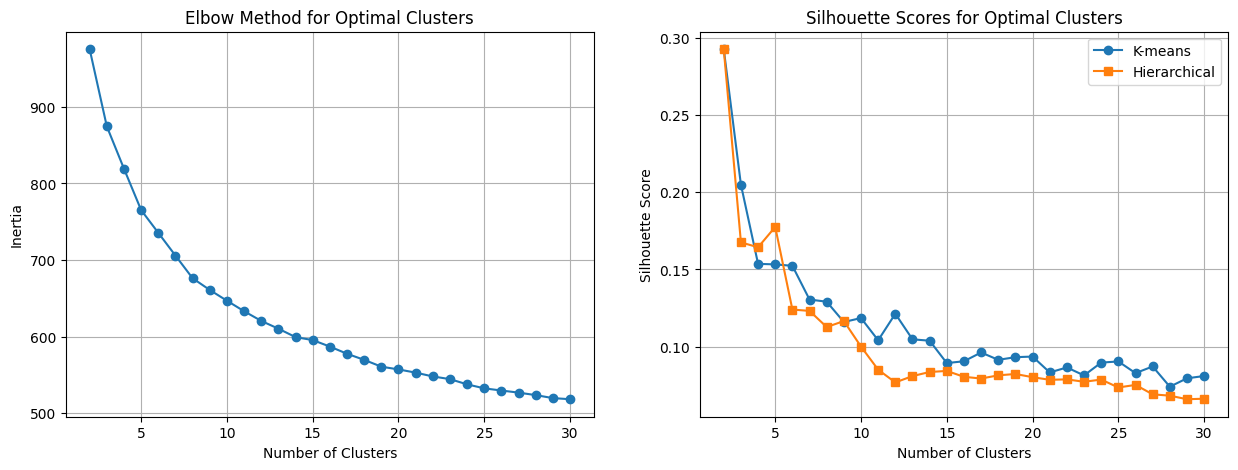

Z-Score Normalization Clustering Evaluation:


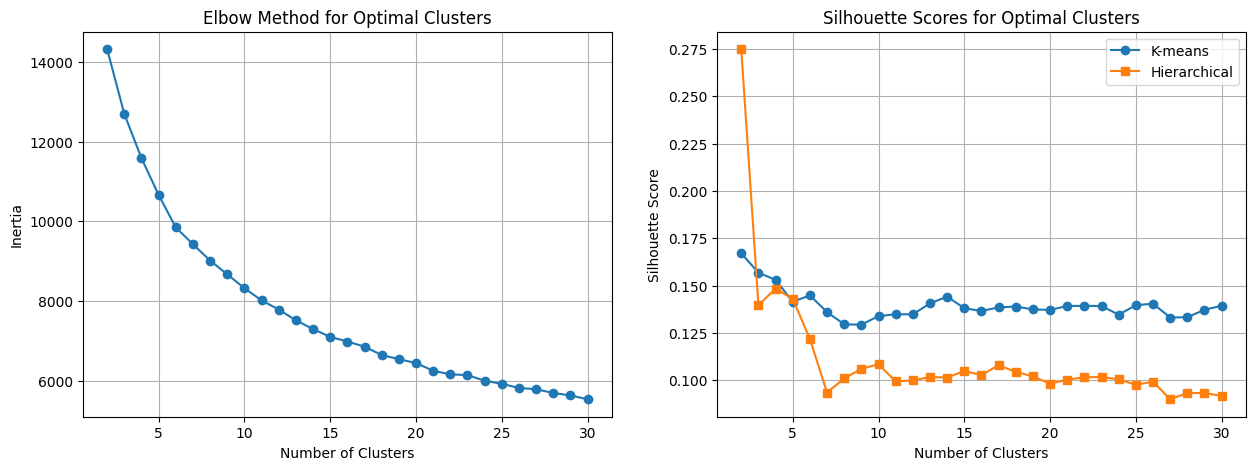

Robust Normalization Clustering Evaluation:


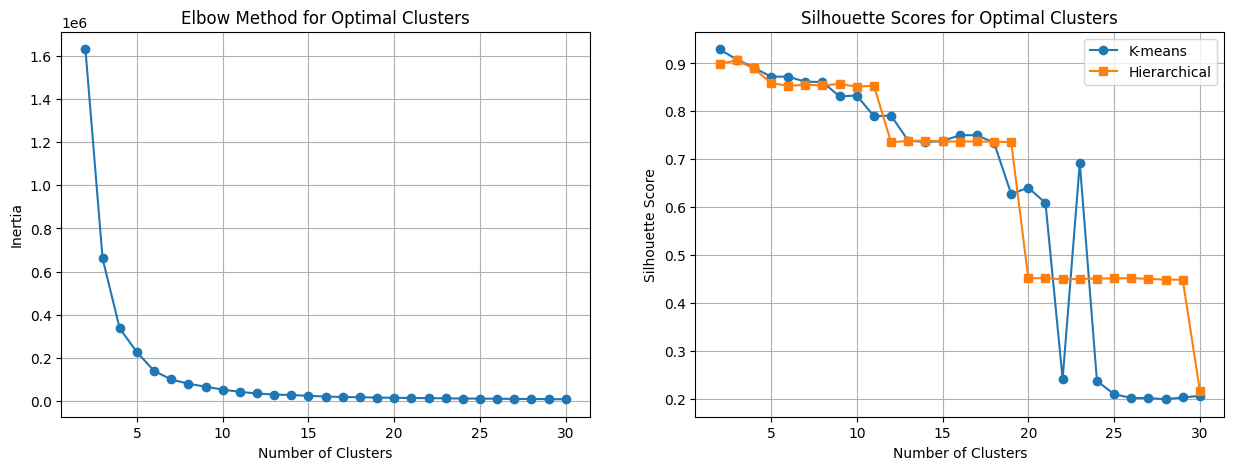

Min-Max Normalization DBSCAN Evaluation: (-1, (None, None))
Z-Score Normalization DBSCAN Evaluation: (-1, (None, None))
Robust Normalization DBSCAN Evaluation: (-1, (None, None))
Min-Max Normalization Gap Statistic Evaluation: 30
Z-Score Normalization Gap Statistic Evaluation: 30
Robust Normalization Gap Statistic Evaluation: 4


In [149]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from gap_statistic import OptimalK
import numpy as np


# Set the range of clusters to test
min_clusters = 2
max_clusters = 30

# Function to evaluate K-means and Hierarchical clustering for a given dataset
def evaluate_clustering_methods(combined_data, min_clusters, max_clusters):
    kmeans_silhouettes = []
    hierarchical_silhouettes = []
    kmeans_inertia = []
    hierarchical_range = range(min_clusters, max_clusters + 1)

    for n_clusters in hierarchical_range:
        # K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, random_state=42)
        kmeans_labels = kmeans.fit_predict(combined_data)

        # Hierarchical clustering
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        hierarchical_labels = hierarchical.fit_predict(combined_data)

        # Calculate silhouette scores
        kmeans_silhouette = silhouette_score(combined_data, kmeans_labels)
        hierarchical_silhouette = silhouette_score(combined_data, hierarchical_labels)

        # Append scores to the corresponding lists
        kmeans_silhouettes.append(kmeans_silhouette)
        hierarchical_silhouettes.append(hierarchical_silhouette)
        kmeans_inertia.append(kmeans.inertia_)

    return kmeans_inertia, kmeans_silhouettes, hierarchical_silhouettes

# Function to plot Elbow method and Silhouette scores
def plot_evaluation_metrics(kmeans_inertia, kmeans_silhouettes, hierarchical_silhouettes, min_clusters, max_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    clusters_range = range(min_clusters, max_clusters + 1)
    
    # Elbow method plot
    ax1.plot(clusters_range, kmeans_inertia, marker='o')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method for Optimal Clusters')
    ax1.grid()

    # Silhouette scores plot
    ax2.plot(clusters_range, kmeans_silhouettes, marker='o', label='K-means')
    ax2.plot(clusters_range, hierarchical_silhouettes, marker='s', label='Hierarchical')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Scores for Optimal Clusters')
    ax2.legend()
    ax2.grid()

    plt.show()
    
# Add the gap_statistic evaluation
def evaluate_gap_statistic(combined_data, min_clusters, max_clusters):
    optimalK = OptimalK(parallel_backend='none')
    n_clusters = optimalK(combined_data, cluster_array=np.arange(min_clusters, max_clusters+1))
    return n_clusters

# Add DBSCAN evaluation
def evaluate_dbscan(combined_data, eps_values, min_samples_values):
    best_score = -1
    best_params = (None, None)

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(combined_data)

            # Ignore results with only one cluster or noise points
            if len(set(dbscan_labels)) <= 2 or -1 in set(dbscan_labels):
                continue

            silhouette = silhouette_score(combined_data, dbscan_labels)

            if silhouette > best_score:
                best_score = silhouette
                best_params = (eps, min_samples)

    return best_score, best_params

# Set parameter ranges for DBSCAN
eps_values = np.linspace(0.1, 0.9, 9)
min_samples_values = list(range(3, 11))

# Evaluate DBSCAN for each normalization method
minmax_dbscan_results = evaluate_dbscan(combined_minmax, eps_values, min_samples_values)
zscore_dbscan_results = evaluate_dbscan(combined_zscore, eps_values, min_samples_values)
robust_dbscan_results = evaluate_dbscan(combined_robust, eps_values, min_samples_values)

# Evaluate gap statistic for each normalization method
minmax_gap_statistic = evaluate_gap_statistic(combined_minmax, min_clusters, max_clusters)
zscore_gap_statistic = evaluate_gap_statistic(combined_zscore, min_clusters, max_clusters)
robust_gap_statistic = evaluate_gap_statistic(combined_robust, min_clusters, max_clusters)

# Evaluate clustering methods for each normalization method
minmax_results = evaluate_clustering_methods(combined_minmax, min_clusters, max_clusters)
zscore_results = evaluate_clustering_methods(combined_zscore, min_clusters, max_clusters)
robust_results = evaluate_clustering_methods(combined_robust, min_clusters, max_clusters)

# Plot evaluation metrics for each normalization method
print("Min-Max Normalization Clustering Evaluation:")
plot_evaluation_metrics(*minmax_results, min_clusters, max_clusters)

print("Z-Score Normalization Clustering Evaluation:")
plot_evaluation_metrics(*zscore_results, min_clusters, max_clusters)

print("Robust Normalization Clustering Evaluation:")
plot_evaluation_metrics(*robust_results, min_clusters, max_clusters)
                        
print("Min-Max Normalization DBSCAN Evaluation:", minmax_dbscan_results)
print("Z-Score Normalization DBSCAN Evaluation:", zscore_dbscan_results)
print("Robust Normalization DBSCAN Evaluation:", robust_dbscan_results)

print("Min-Max Normalization Gap Statistic Evaluation:", minmax_gap_statistic)
print("Z-Score Normalization Gap Statistic Evaluation:", zscore_gap_statistic)
print("Robust Normalization Gap Statistic Evaluation:", robust_gap_statistic)


Evaluating DBSCAN with minmax normalization...


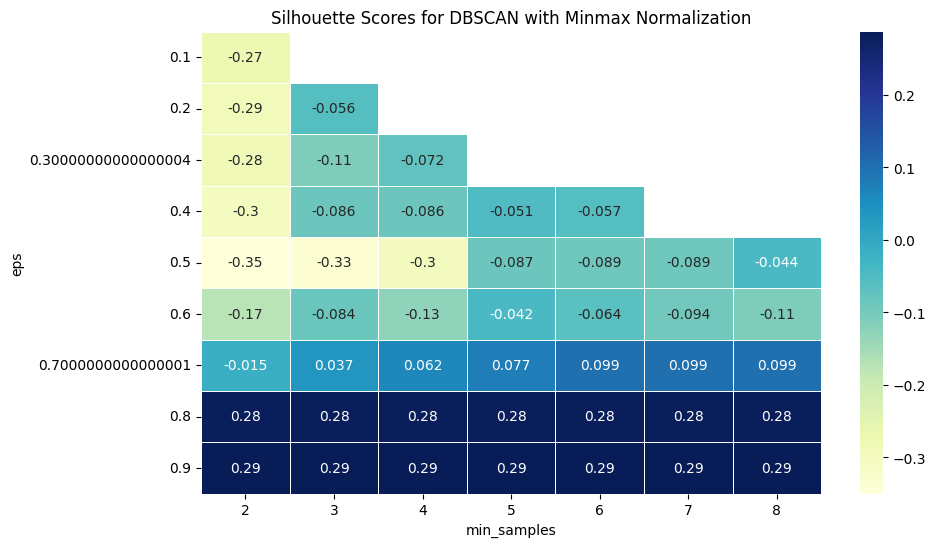

Evaluating DBSCAN with zscore normalization...


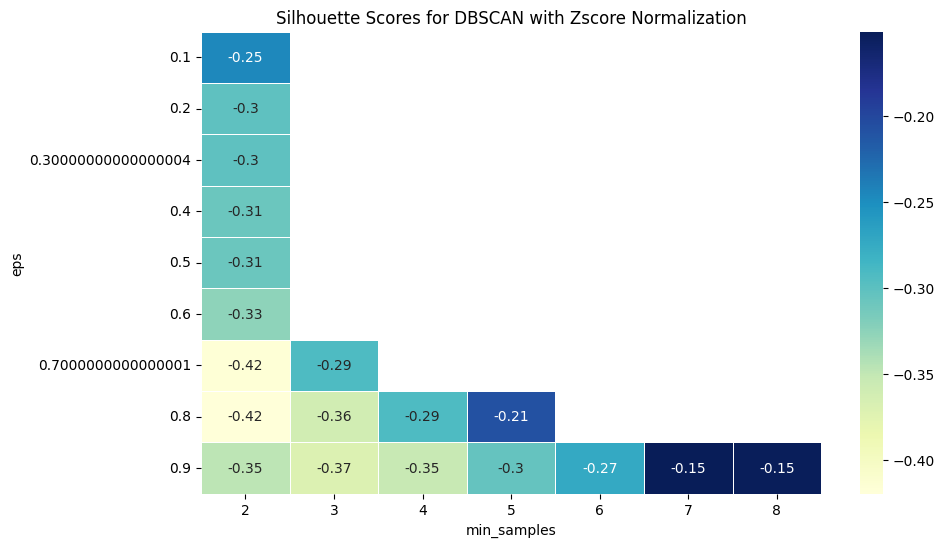

Evaluating DBSCAN with robust normalization...


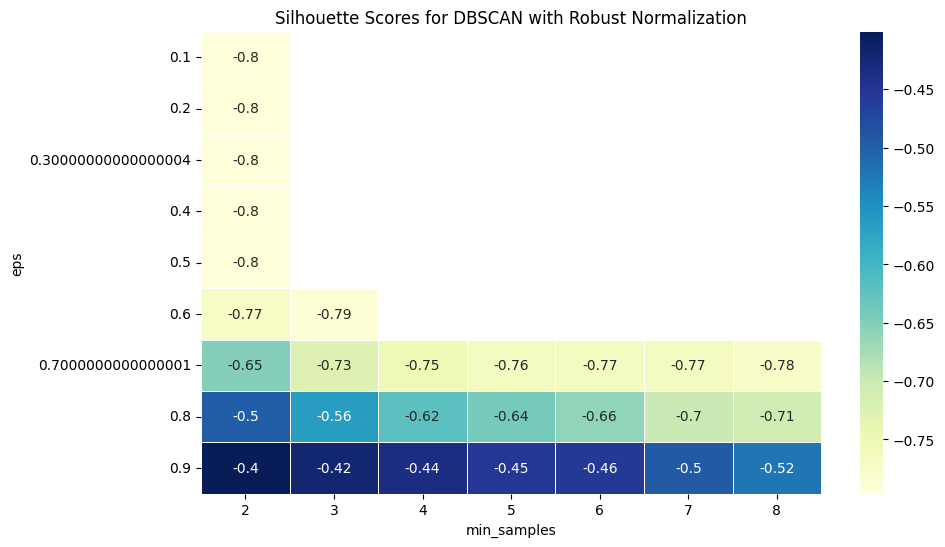

In [166]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Define the range of values for eps and min_samples
eps_values = np.linspace(0.1, 0.9, 9)
min_samples_values = list(range(2, 9))

# Iterate over the normalization methods
for norm_method in ['minmax', 'zscore', 'robust']:
    print(f"Evaluating DBSCAN with {norm_method} normalization...")

    # Normalize the data using the specified method
    data_normalized = normalize_features(df, audio_features, method=norm_method)
    combined_data = combine_features(data_normalized, embeddings)

    # Create an empty DataFrame to store the silhouette scores
    results = pd.DataFrame(index=eps_values, columns=min_samples_values)

    # Iterate over the parameter combinations and evaluate the clustering performance
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(combined_data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # Check if there are at least 2 clusters
            if n_clusters >= 2:
                score = silhouette_score(combined_data, labels)
                results.at[eps, min_samples] = score

    # Create a heatmap from the DataFrame
    plt.figure(figsize=(10, 6))
    results = results.astype(float)
    sns.heatmap(results, annot=True, cmap='YlGnBu', linewidths=0.5)
    plt.title(f"Silhouette Scores for DBSCAN with {norm_method.capitalize()} Normalization")
    plt.xlabel("min_samples")
    plt.ylabel("eps")
    plt.show()

Testing dataset 1 (normalized using MinMax):

Finding feature importances for 30 clusters:

Dataset size: (1752, 1545)
Importances size: (1545,)
indices: [ 942 1229  682 ...    6    3    2]


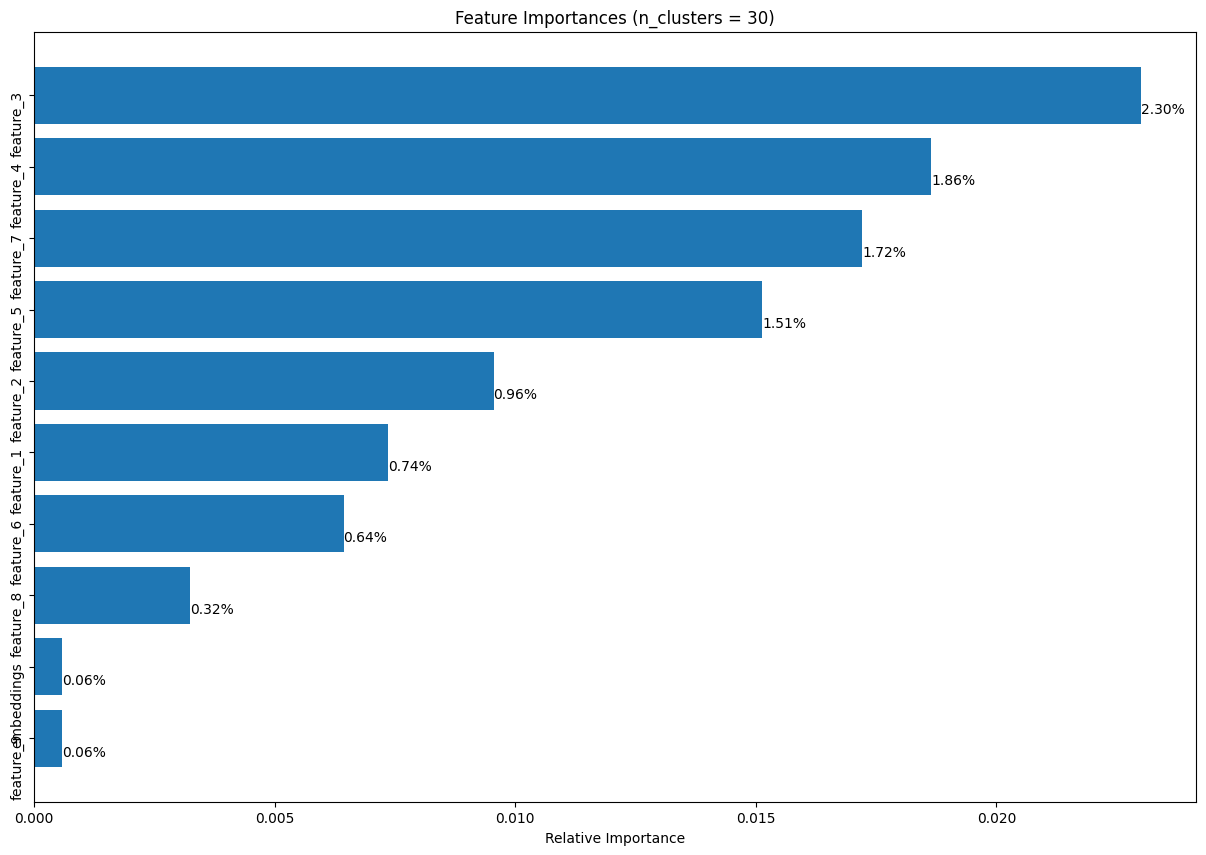

Feature importances for kmeans:
[0.00735142 0.00955092 0.02300286 ... 0.0006949  0.00057855 0.00061301]

Dataset size: (1752, 1545)
Importances size: (1545,)
indices: [1327  970  167 ...    6    2    3]


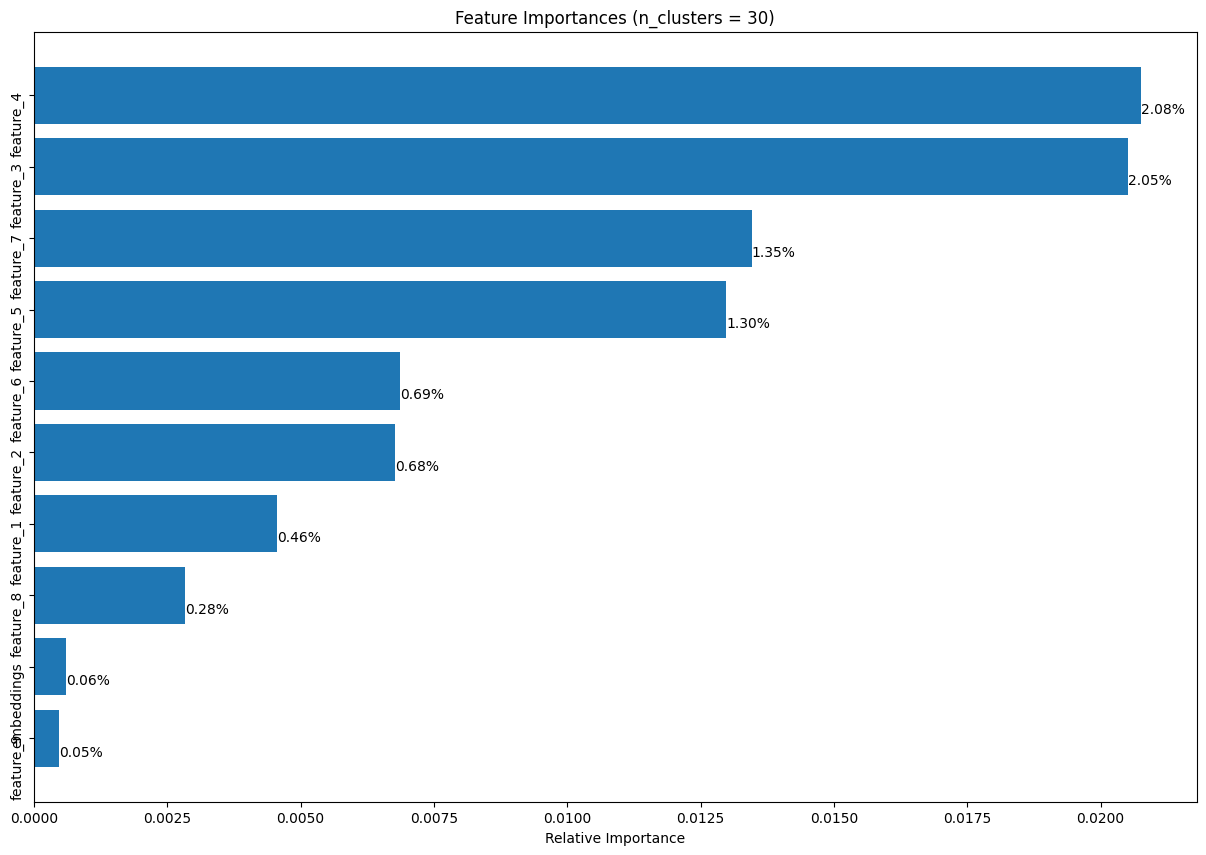

Feature importances for hierarchical:
[0.00456255 0.00676217 0.02052165 ... 0.00059338 0.00060354 0.00073095]

---------------------------------
Testing dataset 2 (normalized using Z-score):

Finding feature importances for 30 clusters:

Dataset size: (1752, 1545)
Importances size: (1545,)
indices: [1215 1142 1282 ...    6    2    3]


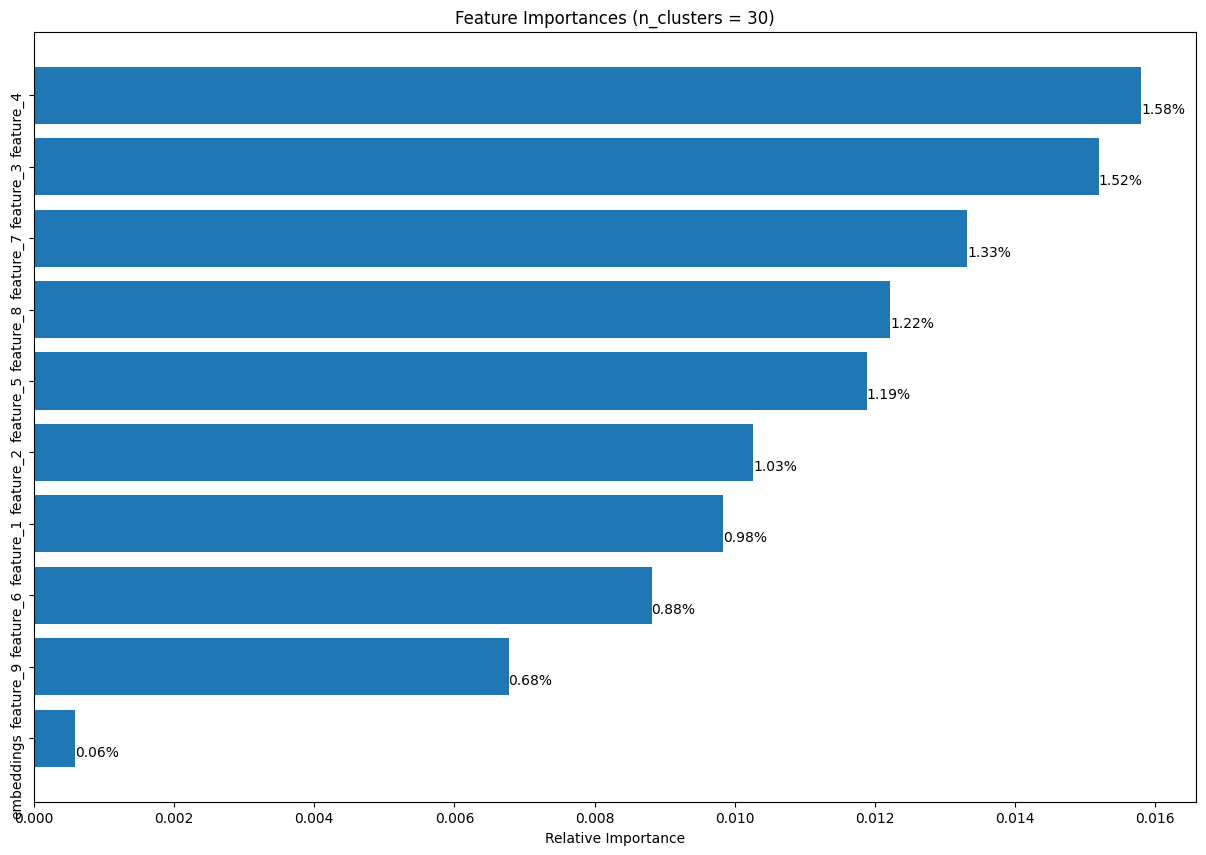

Feature importances for kmeans:
[0.00983093 0.01026502 0.01519362 ... 0.00058255 0.00059331 0.00060951]

Dataset size: (1752, 1545)
Importances size: (1545,)
indices: [1360 1393  185 ...    6    4    3]


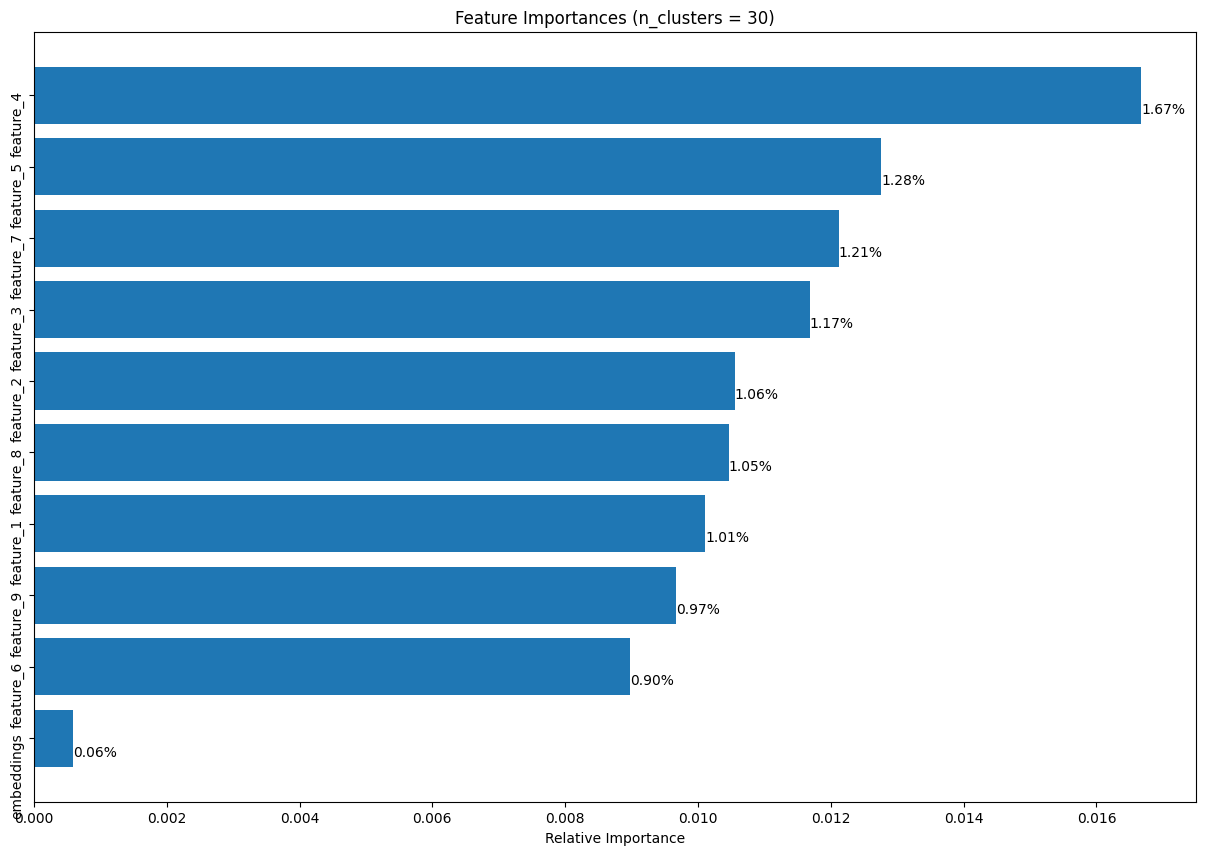

Feature importances for hierarchical:
[0.01011094 0.01055433 0.01168458 ... 0.00058495 0.0005888  0.00043742]

---------------------------------
Testing dataset 3 (normalized using Robust):

Finding feature importances for 30 clusters:

Dataset size: (1752, 1545)
Importances size: (1545,)
indices: [ 121  434 1379 ...    0    5    4]


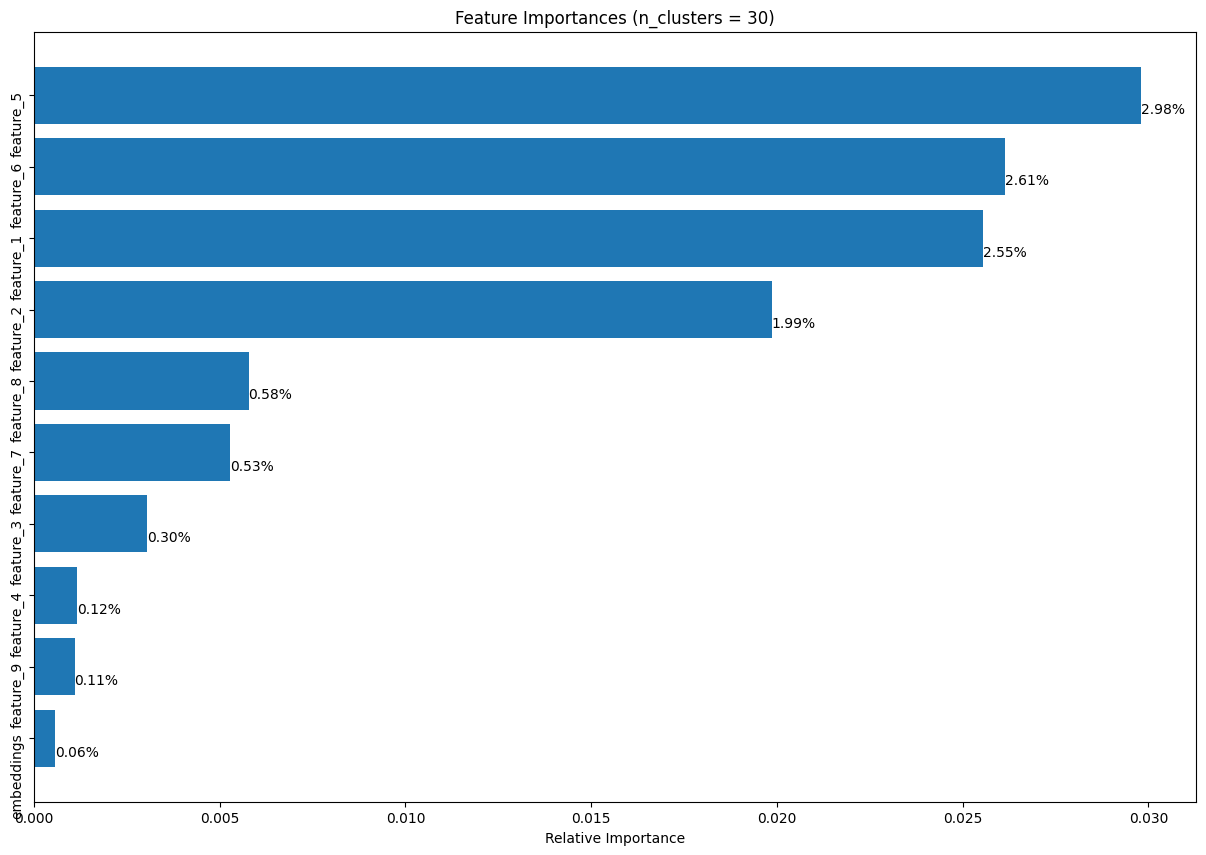

Feature importances for kmeans:
[0.02554438 0.01986214 0.00304217 ... 0.00083813 0.0006621  0.00051601]

Dataset size: (1752, 1545)
Importances size: (1545,)
indices: [430 382 154 ...   1   4   5]


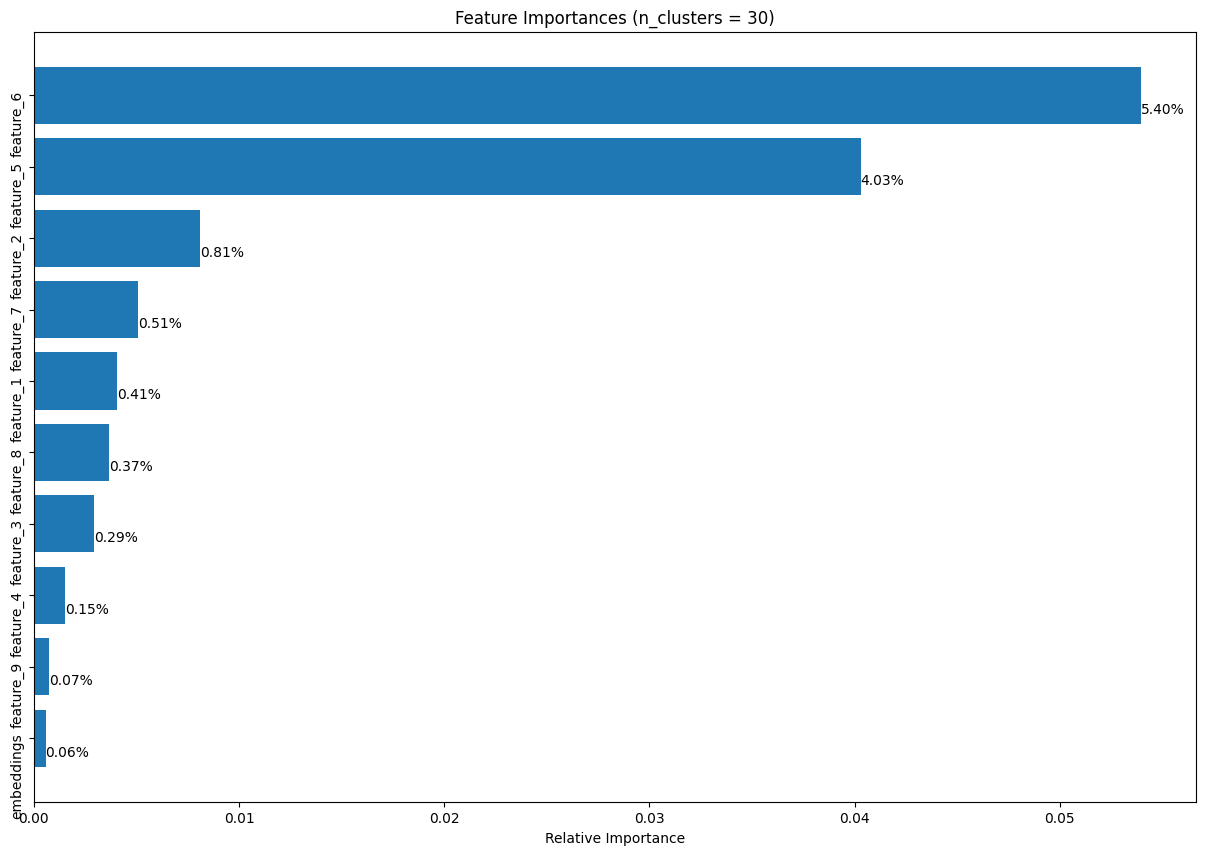

Feature importances for hierarchical:
[0.00406935 0.0081039  0.00293001 ... 0.00067679 0.00056587 0.00050103]

---------------------------------


In [202]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def perform_clustering_and_test_importance(X, n_clusters, algorithm='kmeans'):
    if algorithm == 'kmeans':
        cluster_model = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, random_state=42)
    elif algorithm == 'hierarchical':
        cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
    else:
        raise ValueError(f"Invalid clustering algorithm, choose either 'kmeans' or 'hierarchical'. Given: {algorithm}")

    y = cluster_model.fit_predict(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    feature_importance_model = RandomForestClassifier(n_estimators=1000, random_state=42)
    feature_importance_model.fit(X_train, y_train)

    # Calculate feature importances and return them
    return feature_importance_model.feature_importances_

def plot_feature_importances(importances, feature_names, n_clusters):
    indices = np.argsort(importances)
    plt.figure(figsize=(15, 10))
    plt.title(f"Feature Importances (n_clusters = {n_clusters})")
    plt.barh(range(len(importances)), importances[indices], align='center')
    plt.yticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    for i, (value, index) in enumerate(zip(importances[indices], indices)):
        plt.text(value, i - 0.25, f"{value*100:.2f}%")
    plt.xlabel("Relative Importance")
    plt.show()



# Define an array of features names, e.g.
feature_names = ['danceability', 'energy', 'key', 'mode', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'time_signature', "embeddings"]
datasets = [combined_minmax, combined_zscore, combined_robust]

for i, dataset in enumerate(datasets):
    print(f"Testing dataset {i+1} (normalized using {'MinMax' if i == 0 else ('Z-score' if i == 1 else 'Robust')}):")
    print()

    for n_clusters in range(2, 31):
        print(f"Finding feature importances for {n_clusters} clusters:")
        print()

        for algorithm in ["kmeans", "hierarchical"]:
            importances = perform_clustering_and_test_importance(dataset, n_clusters, algorithm=algorithm)
            if len(importances) > 0:
                if np.isnan(dataset).any():
                    print("Dataset contains NaN values")
                else:
                    print(f"Dataset size: {dataset.shape}")
                    print(f"Importances size: {importances.shape}")
                    indices = np.argsort(importances)
                    print(f"indices: {indices}")
                    print(f"feature_names: {feature_names}")
                    plot_feature_importances(importances, feature_names, n_clusters)
                    print(f"Feature importances for {algorithm}:")
                    print(importances)
            else:
                print(f"No feature importances found for {algorithm}")
            print()

        print("---------------------------------")

In [207]:
df = pd.read_csv('embed.csv')
columns_to_drop = ['Unnamed: 0'] # list the column names to drop
df=df.drop(columns=columns_to_drop)
df.set_index("track_id", inplace=True)

df["embeddings"] = df.embeddings.apply(eval).apply(np.array)  # convert string to numpy array
embeddings = np.vstack(df.embeddings.values)
embeddings.shape

(1752, 1536)

Testing reduced dataset 1 (min-max normalization):

Finding feature importances for 20 clusters:

Dataset size: (1752, 10)
Importances size: (10,)
indices: [8 7 9 0 5 1 3 4 6 2]


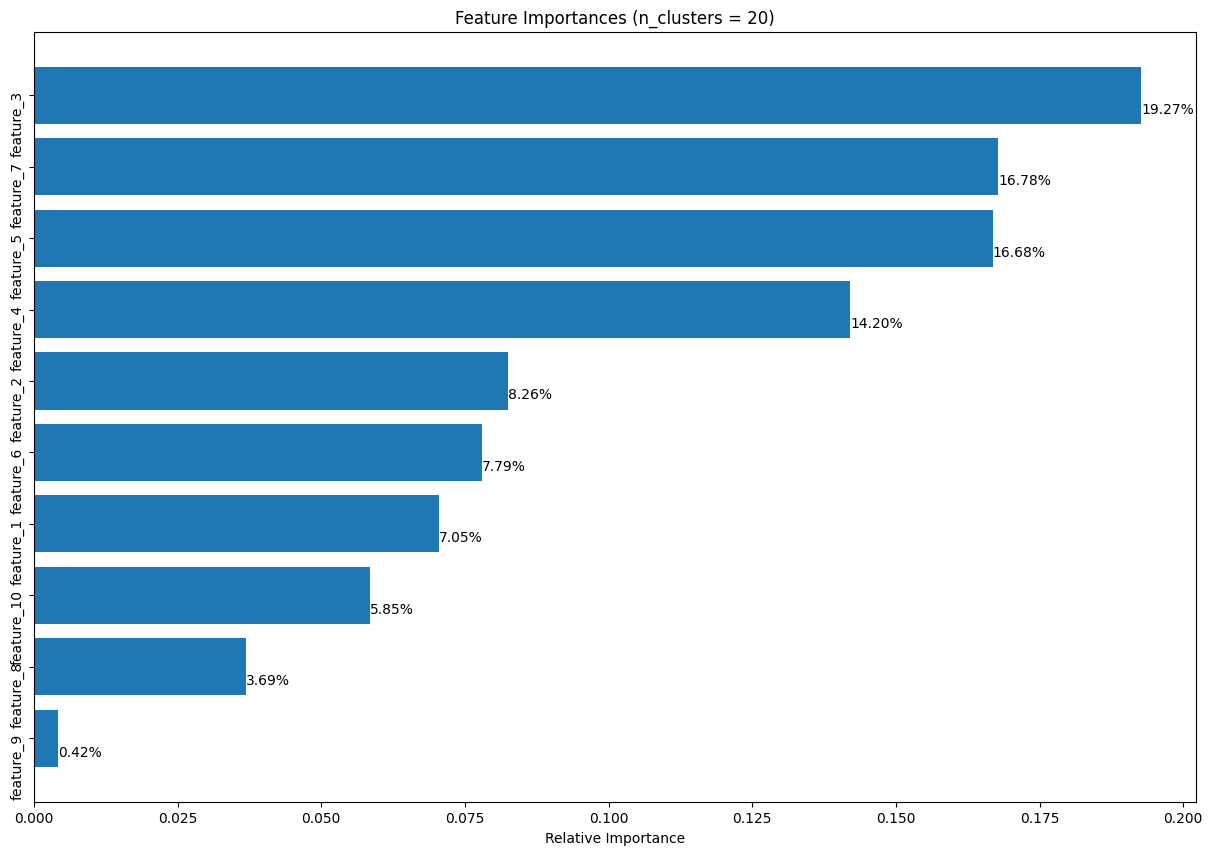

Feature importances for kmeans:
[0.07053843 0.08257889 0.19265444 0.1420463  0.16684633 0.07792661
 0.16780097 0.03693623 0.00417008 0.05850173]

Dataset size: (1752, 10)
Importances size: (10,)
indices: [8 7 9 0 1 5 3 6 4 2]


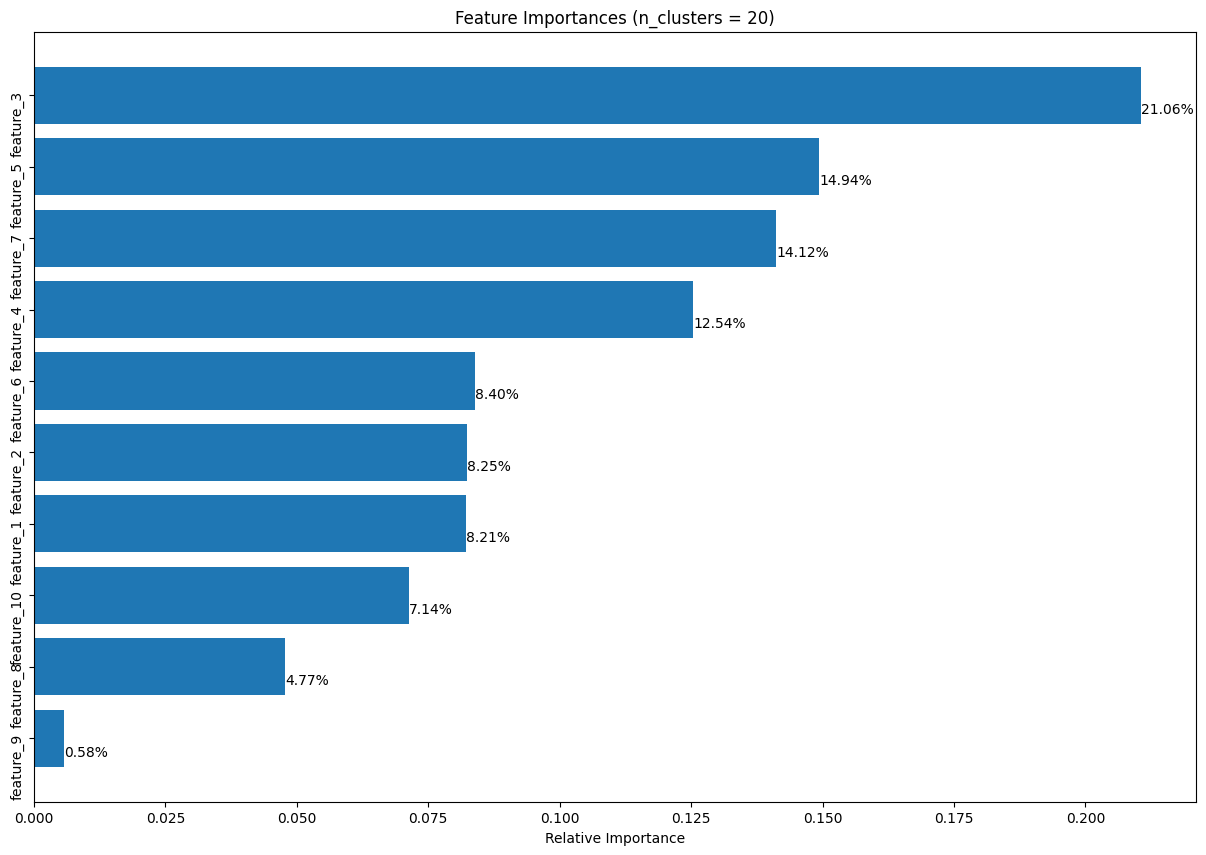

Feature importances for hierarchical:
[0.0821024  0.08247146 0.21056352 0.1254211  0.14935055 0.08398073
 0.1412189  0.0477461  0.00576718 0.07137807]

---------------------------------
Testing reduced dataset 2 (z-score normalization):

Finding feature importances for 20 clusters:

Dataset size: (1752, 10)
Importances size: (10,)
indices: [9 8 5 3 1 4 0 2 7 6]


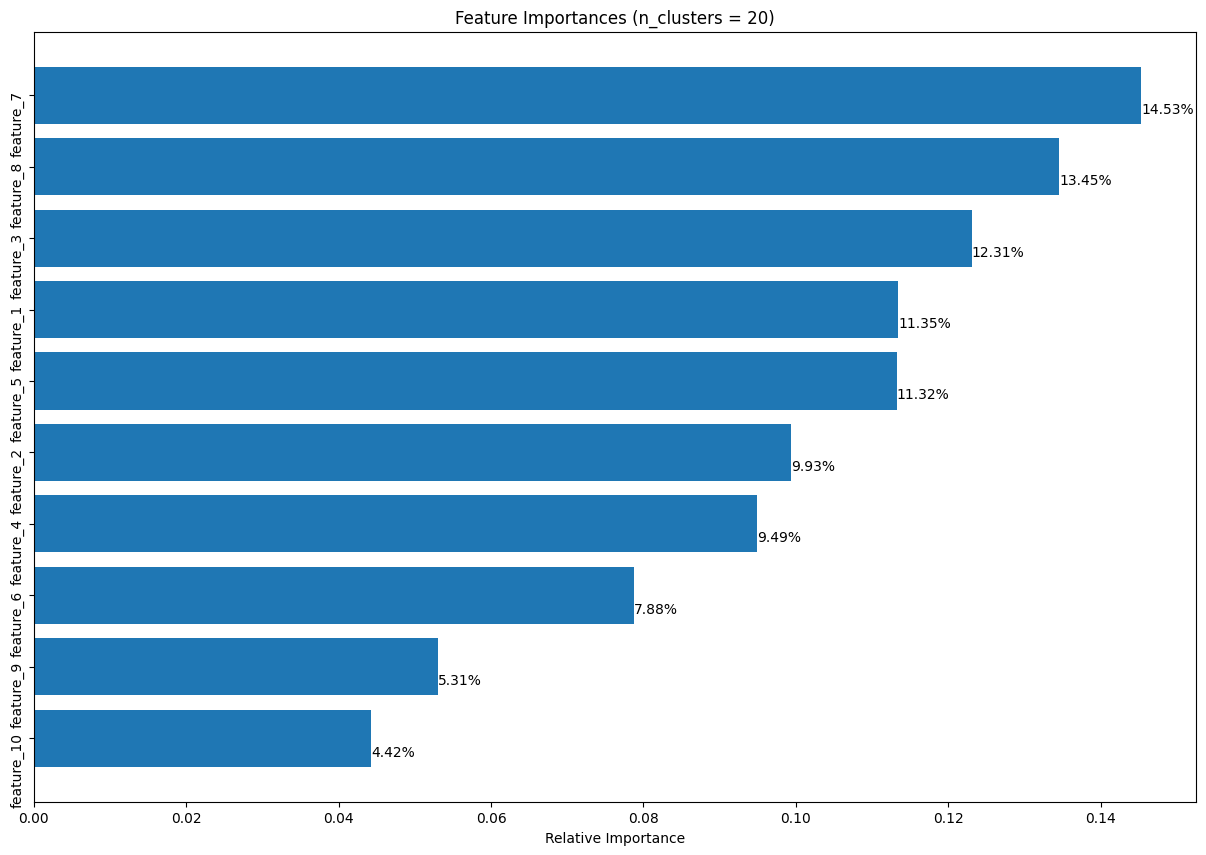

Feature importances for kmeans:
[0.11346414 0.09934513 0.12310794 0.09489463 0.11324859 0.07878687
 0.14529958 0.13454011 0.0530766  0.04423642]

Dataset size: (1752, 10)
Importances size: (10,)
indices: [9 8 3 5 1 0 7 2 6 4]


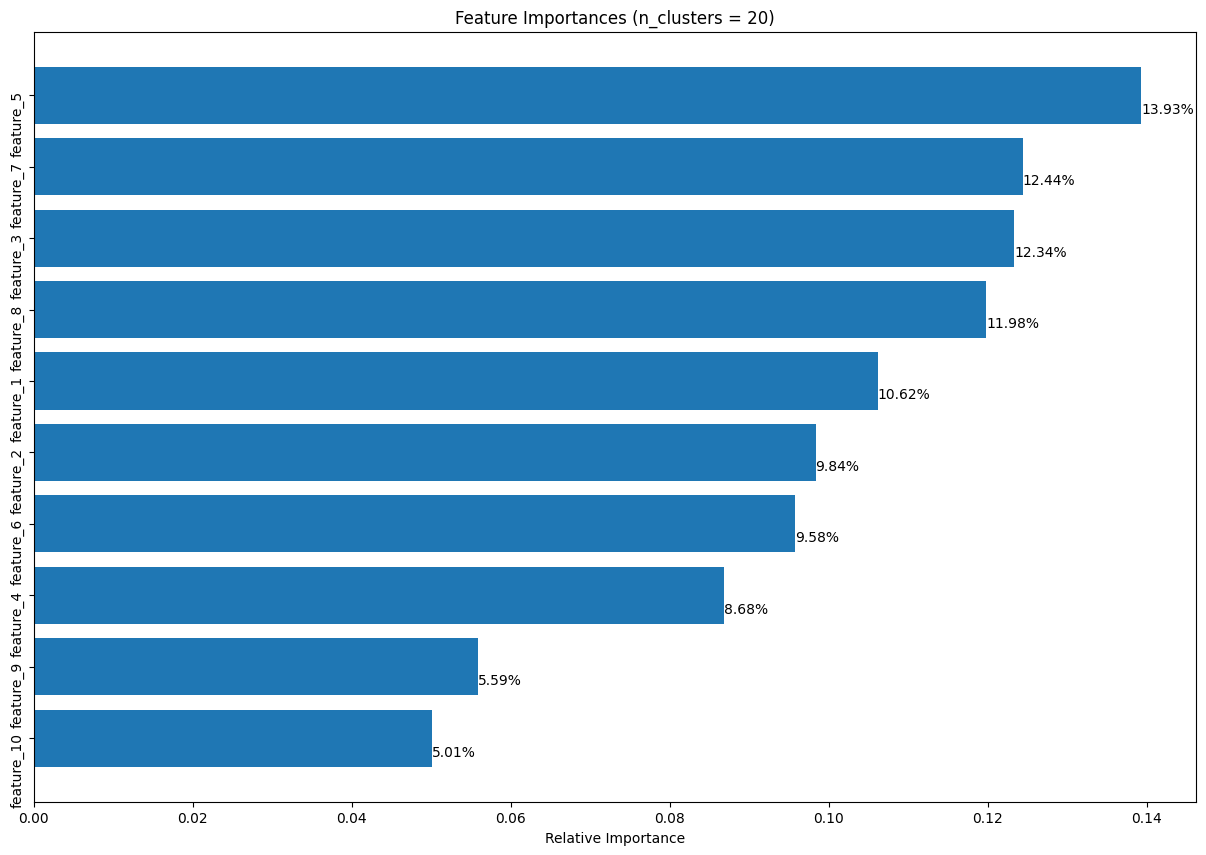

Feature importances for hierarchical:
[0.10618193 0.09835552 0.12335434 0.08682328 0.13929762 0.09576527
 0.12442996 0.11982575 0.05585948 0.05010683]

---------------------------------
Testing reduced dataset 3 (robust normalization):

Finding feature importances for 20 clusters:

Dataset size: (1752, 10)
Importances size: (10,)
indices: [8 3 2 7 0 6 1 4 9 5]


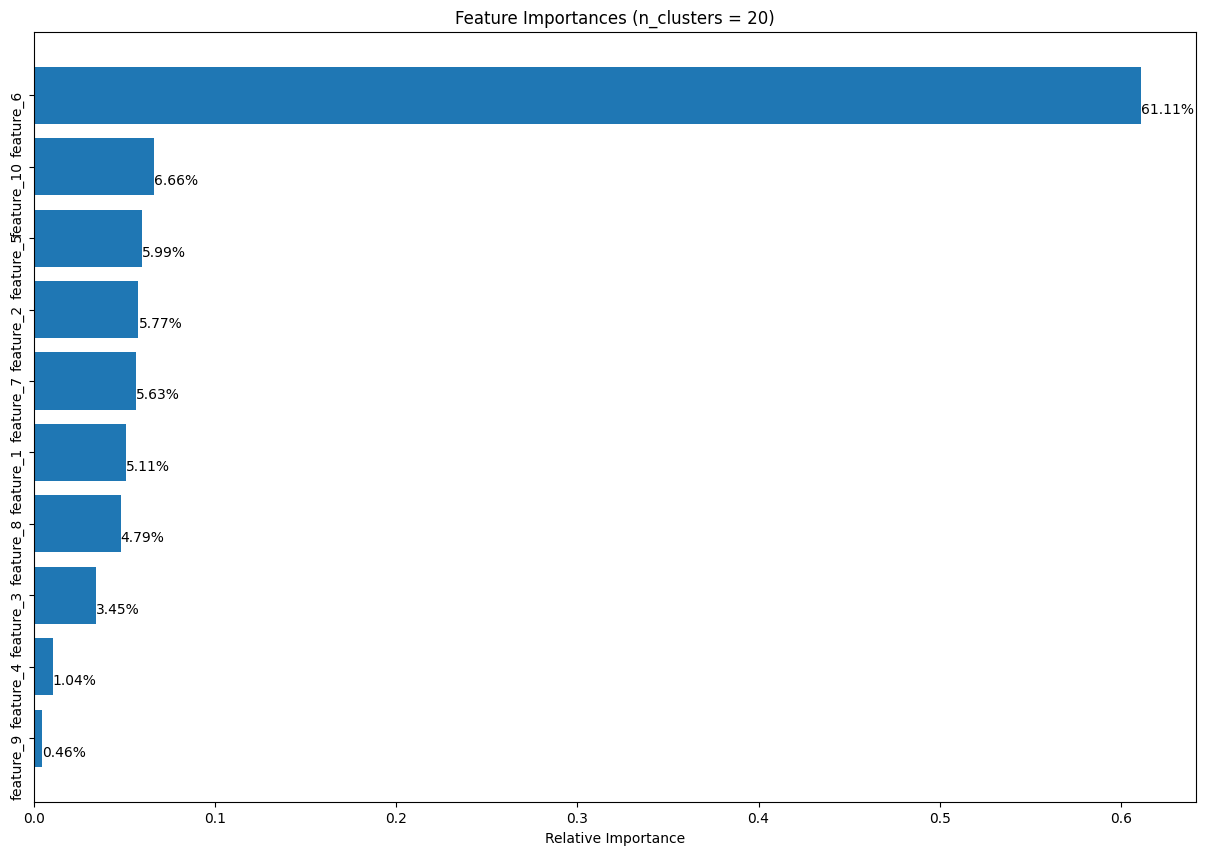

Feature importances for kmeans:
[0.0510664  0.05773373 0.0344714  0.0103987  0.05986605 0.61113221
 0.05629661 0.04789146 0.00457722 0.06656622]

Dataset size: (1752, 10)
Importances size: (10,)
indices: [8 3 2 7 0 6 4 1 9 5]


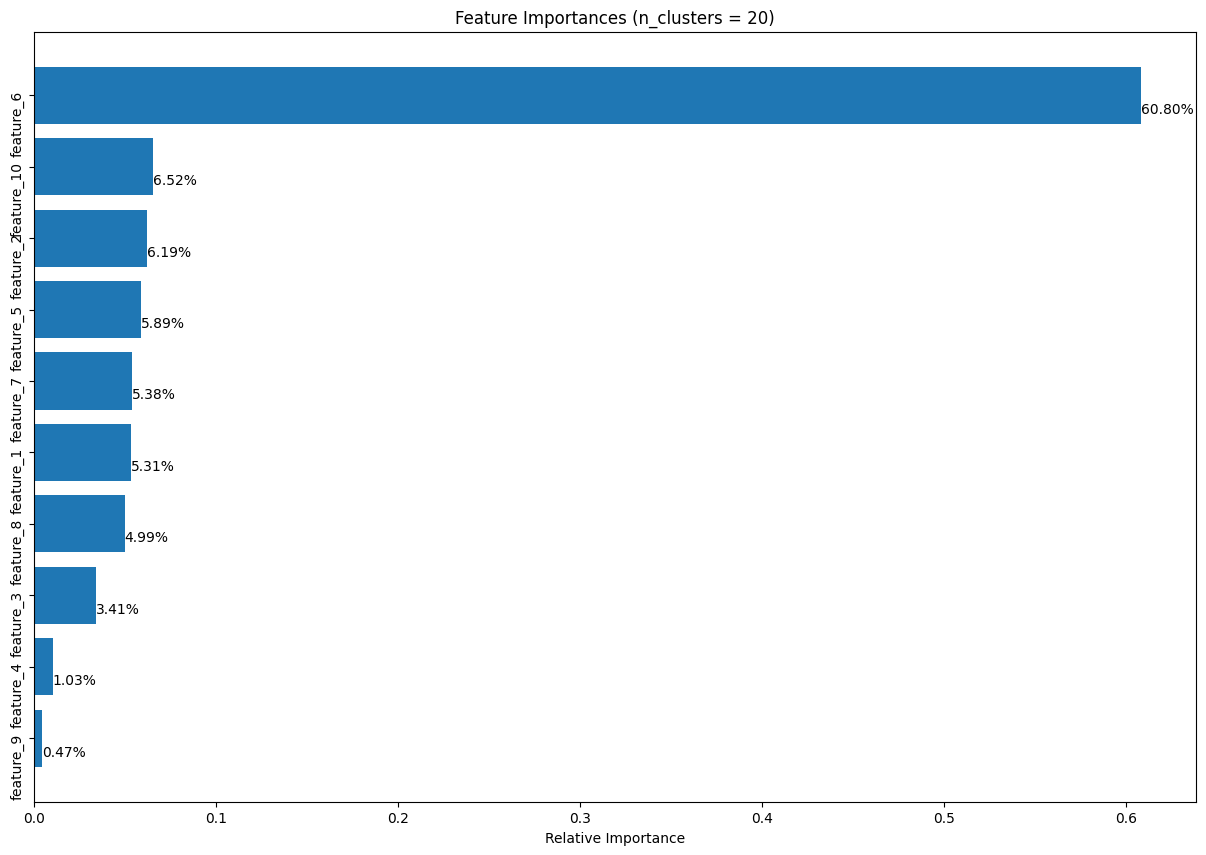

Feature importances for hierarchical:
[0.05313303 0.06187671 0.03411681 0.01027822 0.05887897 0.60799841
 0.05383058 0.04994321 0.00472316 0.0652209 ]

---------------------------------


In [216]:
from sklearn.decomposition import PCA


def reduce_dimensionality(embeddings, n_components=1):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings


# Reduce the dimensionality of the embeddings using PCA
n_components = 1
reduced_embeddings = reduce_dimensionality(embeddings, n_components=n_components)

r_combined_minmax = combine_features(np_minmax, reduced_embeddings)
r_combined_zscore = combine_features(np_zscore, reduced_embeddings)
r_combined_robust = combine_features(np_robust, reduced_embeddings)

datasets = [
    ("min-max", r_combined_minmax),
    ("z-score", r_combined_zscore),
    ("robust", r_combined_robust),
]

for i, (name, dataset) in enumerate(datasets):
    print(f"Testing reduced dataset {i+1} ({name} normalization):")
    print()
    
    for n_clusters in range(20,21):
        print(f"Finding feature importances for {n_clusters} clusters:")
        print()
        
        for algorithm in ["kmeans", "hierarchical"]:
            importances = perform_clustering_and_test_importance(dataset, n_clusters, algorithm=algorithm)
            if len(importances) > 0:
                if np.isnan(dataset).any():
                    print("Dataset contains NaN values")
                else:
                    print(f"Dataset size: {dataset.shape}")
                    print(f"Importances size: {importances.shape}")
                    indices = np.argsort(importances)
                    print(f"indices: {indices}")
                    plot_feature_importances(importances, feature_names, n_components, n_clusters)
                    print(f"Feature importances for {algorithm}:")
                    print(importances)
            else:
                print(f"No feature importances found for {algorithm}")
            print()
        print("---------------------------------")

In [212]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

df = pd.read_csv('embed.csv')
columns_to_drop = ['Unnamed: 0'] # list the column names to drop
df=df.drop(columns=columns_to_drop)
df.set_index("track_id", inplace=True)

df["embeddings"] = df.embeddings.apply(eval).apply(np.array)  # convert string to numpy array
embeddings = np.vstack(df.embeddings.values)
embeddings.shape

r_combined_minmax = combine_features(np_minmax, reduced_embeddings)
r_combined_zscore = combine_features(np_zscore, reduced_embeddings)
r_combined_robust = combine_features(np_robust, reduced_embeddings)

datasets = [
    ("min-max", r_combined_minmax),
    ("z-score", r_combined_zscore),
    ("robust", r_combined_robust),
]

# Define the function to reduce dimensionality
def reduce_dimensionality(embeddings, n_components=100):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

def perform_clustering_and_test_importance(X, n_clusters, algorithm='kmeans'):
    if algorithm == 'kmeans':
        cluster_model = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, random_state=42)
    elif algorithm == 'hierarchical':
        cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
    else:
        raise ValueError(f"Invalid clustering algorithm, choose either 'kmeans' or 'hierarchical'. Given: {algorithm}")

    y = cluster_model.fit_predict(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    feature_importance_model = RandomForestClassifier(n_estimators=1000, random_state=42)
    feature_importance_model.fit(X_train, y_train)

    # Calculate feature importances and return them
    return feature_importance_model.feature_importances_


# Define the function to calculate the average importance
def calculate_average_importance(importances):
    return np.mean(importances)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["Normalization", "Algorithm", "N_Clusters", "N_Dimensions", "Avg_Feature_Importance"])

# Define the lists of dimensions and clusters
n_dimensions_list = [1536, 100, 10, 1]  # list of desired dimensions

for i, (name, dataset) in enumerate(datasets):
    for n_dimensions in n_dimensions_list:
        if n_dimensions == 1536:
            reduced_embeddings = embeddings
        else:
            reduced_embeddings = reduce_dimensionality(embeddings, n_components=n_dimensions)

        for n_clusters in [5, 15, 30]:
            for algorithm in ["kmeans", "hierarchical"]:
                importances = perform_clustering_and_test_importance(dataset, n_clusters, algorithm=algorithm)
                if len(importances) > 0:
                    avg_importance = calculate_average_importance(importances)
                    row = pd.DataFrame({
                        "Normalization": [name],
                        "Algorithm": [algorithm],
                        "N_Clusters": [n_clusters],
                        "N_Dimensions": [n_dimensions],
                        "Avg_Feature_Importance": [avg_importance],
                    })
                    results_df = pd.concat([results_df, row], ignore_index=True)

# Display the results DataFrame
print(results_df)



   Normalization     Algorithm N_Clusters N_Dimensions  Avg_Feature_Importance
0        min-max        kmeans          5         1536                0.009174
1        min-max  hierarchical          5         1536                0.009174
2        min-max        kmeans         10         1536                0.009174
3        min-max  hierarchical         10         1536                0.009174
4        min-max        kmeans         20         1536                0.009174
..           ...           ...        ...          ...                     ...
91        robust  hierarchical         10            1                0.009174
92        robust        kmeans         20            1                0.009174
93        robust  hierarchical         20            1                0.009174
94        robust        kmeans         30            1                0.009174
95        robust  hierarchical         30            1                0.009174

[96 rows x 5 columns]


In [160]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from gap_statistic import OptimalK
from consensus_clustering import ConsensusCluster

def create_base_clusterers(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, random_state=42)
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    return [kmeans, hierarchical]

def evaluate_consensus_clustering(data1, data2, min_clusters, max_clusters):
    elbow_inertia = []
    silhouette_scores = []
    gap_statistic_scores = []

    for n_clusters in range(min_clusters, max_clusters + 1):
        base_clusterers = create_base_clusterers(n_clusters)
        consensus_clustering = ConsensusCluster(base_clusterers, n_clusters, n_init=100, random_state=42)
        consensus_labels = consensus_clustering.fit_predict([data1, data2])

        # Elbow method
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, random_state=42)
        kmeans.fit(data1)
        elbow_inertia.append(kmeans.inertia_)

        # Silhouette score
        silhouette_scores.append(silhouette_score(data1, consensus_labels))

        # Gap statistic
        optimalK = OptimalK(parallel_backend='none')
        n_clusters_gap = optimalK(data1, cluster_array=np.arange(n_clusters, n_clusters+1))
        gap_statistic_scores.append(n_clusters_gap)

    return elbow_inertia, silhouette_scores, gap_statistic_scores




KeyboardInterrupt

